### Evaluation UNET200

- Intersection Over Union (IOU)

- Dice score / F1 Score

- Pixel Accuracy

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os

In [8]:
# import UNET200 trained

# Double convolution layer
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        # define double convolution operation
        self.operation = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.operation(x)

# Self-Attention layer
class SelfAttention(nn.Module):
    def __init__(self, semantic):
        super(SelfAttention, self).__init__()

        # overlapping embedding (query, key, value)
        self.query = nn.Conv2d(in_channels=semantic, out_channels=semantic, kernel_size=3, stride=1, padding=1)
        self.key = nn.Conv2d(in_channels=semantic, out_channels=semantic, kernel_size=3, stride=1, padding=1)
        self.value = nn.Conv2d(in_channels=semantic, out_channels=semantic, kernel_size=3, stride=1, padding=1)

        # normalization constant
        self.normalizer = sqrt(semantic * 4)

        self.flatten = nn.Flatten(2, 3)  # flatten for the attention calculation

    def forward(self, x):
        b, c, h, w = x.size()

        # Apply query, key, and value convolutions
        q = self.flatten(self.query(x))
        k = self.flatten(self.key(x))
        v = self.flatten(self.value(x))

        # Compute scaled dot-product attention
        scaled = torch.bmm(q, k.permute(0, 2, 1)) / self.normalizer

        # Attention output reshaped back into original size
        return torch.bmm(F.softmax(scaled, dim=-1), v).reshape(b, c, h, w)



# create model

class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()

        # input [1, 176, 128]

        # encoder
        self.encoder1 = DoubleConv(in_channels=1, out_channels=8)
        self.selfatt1 = SelfAttention(8)
        self.encoder2 = DoubleConv(in_channels=8, out_channels=128)
        self.selfatt2 = SelfAttention(128)
        self.encoder3 = DoubleConv(in_channels=128, out_channels=1024)
        self.selfatt3 = SelfAttention(1024)
        self.encoder4 = DoubleConv(in_channels=1024, out_channels=2048)
        self.selfatt4 = SelfAttention(2048)

        # bottleneck
        self.bottom_conv = nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=3, stride=1, padding=1)
        self.bottom_normalizer = nn.BatchNorm2d(num_features=2048)
        self.unity_conv = nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=1, stride=1, padding=0)

        # decoder
        self.transpose3 = nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.decoder3 = DoubleConv(in_channels=2048, out_channels=1024)

        self.transpose2 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.decoder2 = DoubleConv(in_channels=256, out_channels=128)

        self.transpose1 = nn.ConvTranspose2d(in_channels=128, out_channels=8, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.decoder1 = DoubleConv(in_channels=16, out_channels=8)

        self.final_conv = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=1)


        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        # encoder
        enc1 = self.selfatt1(self.encoder1(x)) # [8, 176, 128]
        enc2 = self.selfatt2(self.encoder2(self.pool(enc1))) # [128, 88, 64]
        enc3 = self.selfatt3(self.encoder3(self.pool(enc2))) # [1024, 44, 32]
        enc4 = self.selfatt4(self.encoder4(self.pool(enc3))) # [2048, 22, 16]


        # bottleneck
        bottom1 = self.relu(self.bottom_normalizer(self.bottom_conv(enc4)))
        bottom2 = self.relu(self.bottom_normalizer(self.unity_conv(bottom1)))

        # decoder
        dec3 = self.decoder3(torch.cat([self.transpose3(bottom2), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.transpose2(dec3), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.transpose1(dec2), enc1], dim=1))

        final = self.final_conv(dec1)

        return final
    
    

In [11]:
model = UNET()

model.load_state_dict(torch.load(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\model\UNET200.pth', map_location=torch.device('cpu')))

model

UNET(
  (encoder1): DoubleConv(
    (operation): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (selfatt1): SelfAttention(
    (query): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (key): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (value): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (encoder2): DoubleConv(
    (operation): Sequential(
      (0): Conv2d(8, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [14]:
# import dataset

class LabMemsDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.images = os.listdir(img_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name) # corresponding images and masks have same name

        image = Image.open(img_path).convert("L") # "L" is for grayscale images (1 channel)
        mask = Image.open(mask_path).convert("L")

        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask
    
# initialize transforms

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.442, std=0.225)
])

mask_transform = transforms.Compose([
    transforms.ToTensor()
])

train_image_dir = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\input'
train_mask_dir = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\label'

test_image_dir = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\test-data\input'
test_mask_dir = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\test-data\label'

train_dataset = LabMemsDataset(img_dir=train_image_dir, mask_dir=train_mask_dir, img_transform=image_transform, mask_transform=mask_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = LabMemsDataset(img_dir=test_image_dir, mask_dir=test_mask_dir, img_transform=image_transform, mask_transform=mask_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
print(f"train data: {len(train_dataset)}")
print(f"test data: {len(test_dataset)}")

train data: 4199
test data: 221


In [17]:
test_list = list(test_loader)

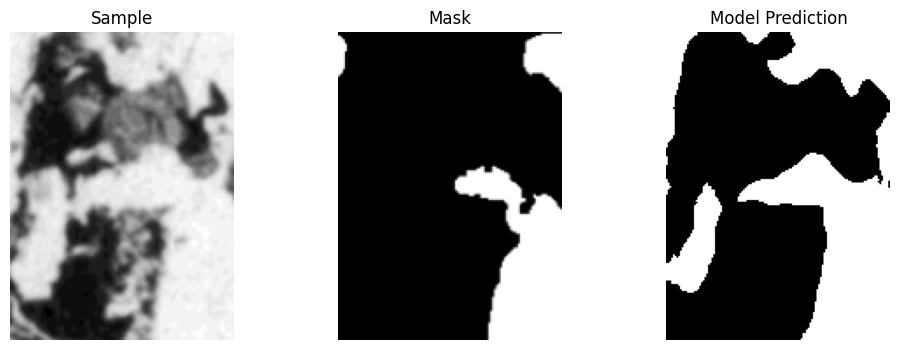

In [27]:
sample, mask = test_list[7]

pred = model(sample).detach()

sig = nn.Sigmoid()

pred = sig(pred)

pred = (pred >= 0.5).float()


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(sample[0].permute(1, 2, 0).numpy(), cmap='gray')
axs[0].set_title('Sample')
axs[0].axis('off')

axs[1].imshow(mask[0].permute(1, 2, 0).numpy(), cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('off')

axs[2].imshow(pred[0].permute(1, 2, 0).numpy(), cmap='gray')
axs[2].set_title('Model Prediction')
axs[2].axis('off')

plt.show()

In [28]:
# define evaluation metrics

import numpy as np

def iou(pred_mask, true_mask):
    """
    Compute Intersection over Union (IoU) between two segmentation masks.
    
    Args:
        pred_mask (np.array): Predicted segmentation mask.
        true_mask (np.array): Ground truth segmentation mask.
        
    Returns:
        float: IoU score.
    """
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union != 0 else 0


def dice_coefficient(pred_mask, true_mask):
    """
    Compute Dice Coefficient (F1 Score) between two segmentation masks.
    
    Args:
        pred_mask (np.array): Predicted segmentation mask.
        true_mask (np.array): Ground truth segmentation mask.
        
    Returns:
        float: Dice score.
    """
    intersection = np.logical_and(pred_mask, true_mask).sum()
    return (2 * intersection) / (pred_mask.sum() + true_mask.sum()) if (pred_mask.sum() + true_mask.sum()) != 0 else 0


def pixel_accuracy(pred_mask, true_mask):
    """
    Compute Pixel Accuracy between two segmentation masks.
    
    Args:
        pred_mask (np.array): Predicted segmentation mask.
        true_mask (np.array): Ground truth segmentation mask.
        
    Returns:
        float: Pixel accuracy score.
    """
    correct_pixels = np.equal(pred_mask, true_mask).sum()
    total_pixels = true_mask.size
    return correct_pixels / total_pixels


In [37]:
sample, mask = test_list[12]

pred = model(sample).detach()

sig = nn.Sigmoid()

pred = sig(pred)

pred = (pred >= 0.5).float()

iou(pred.numpy(), mask.numpy())



0.6549778603056706

In [39]:
total_iou = 0.0
total_dice = 0.0
total_pxac = 0.0

for samples, mask in test_list:
    with torch.inference_mode():
        pred = model(sample).detach()

    sig = nn.Sigmoid()

    pred = sig(pred)

    pred = (pred >= 0.5).float()

    total_iou += iou(pred.numpy(), mask.numpy())
    total_dice += dice_coefficient(pred.numpy(), mask.numpy())
    total_pxac += pixel_accuracy(pred.numpy(), mask.numpy())

total_iou /= len(test_list)
total_dice /= len(test_list)
total_pxac /= len(test_list)

print(f"Intersection Over Union: {total_iou}")
print(f"dice coefficient: {total_dice}")
print(f"pixel accuracy: {total_pxac}")

Intersection Over Union: 0.27604748363337034
dice coefficient: 0.4384160915851789
pixel accuracy: 0.48159856572655274
